In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from functools import reduce
import dateutil.parser as dateparser
from datetime import datetime
import re
import pdb
from tqdm import tqdm
from collections import Counter

In [2]:
import spacy
from spacy.lang.en import English

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
nlp_en = English()

In [5]:
Path.ls = lambda self: [fn for fn in self.glob('*')]

In [6]:
PATH = Path('../input/cityofla/CityofLA/')
bulletins = PATH/'Job Bulletins'

## Looking at a Job listing

In [8]:
fn = bulletins.ls()[39]

In [9]:
with open(fn, encoding='latin-1') as f:
    print(fn.name)
    print(''.join(f.readlines()[:10]))

POLICE COMMANDER 2251 092917.txt
POLICE COMMANDER	
	Class Code:       2251
	Open Date:  09-29-17
(Exam Open to Current City Employees)

ANNUAL SALARY	

$183,472 to $215,899

NOTE:



### Finding all columns

In [10]:
def new_data():
    return {
        'File Name': [],
        'Class Code': [],
        'Job Title': [],
        'Open Date': [],
        'ANNUAL SALARY': [],
        'DUTIES': [],
        'REQUIREMENTS': [],
        'WHERE TO APPLY': [],
        'APPLICATION DEADLINE': [],
        'SELECTION PROCESS': []
    }

sections = ['ANNUAL SALARY', 'DUTIES', 'REQUIREMENTS', 'WHERE TO APPLY', 'APPLICATION DEADLINE', 'SELECTION PROCESS']

def is_open_date(line):
    return line.startswith('Open Date:')

def on_open_date(data, key, value):
    data[key][-1] = dateparser.parse(value.split()[2])
    key, value = None, None
    return key, value

def is_section_begin(sections, line):
    def _startswith(n=None):
        return len(list(filter(lambda section: line.startswith(section[:n]), sections)))>0
    return (line in sections) or _startswith() or _startswith(n=-1)

def get_section_key(sections, line):
    if line in sections:
        return line
    # find appropriate key, e.g. REQUIREMENTS/MINIMUM QUALIFICATIONS -> REQUIREMENTS
    for section in sections:
        if line.startswith(section) or line.startswith(section[:-1]):
            return section

def on_section_begin(data, key, value):
    return key, value

def on_section_end(data, key, value):
    if key is not None:
        key = get_section_key(sections, key)
        data[key][-1] = value
        key, value = None, None
    return key, value

def add_row(data, sections):
    for section in sections:
        data[section].append('')

def parse_sections(f, data, sections):
    add_row(data, sections + ['File Name', 'Job Title', 'Class Code', 'Open Date'])
    data['File Name'][-1] = fn.name
    key, value = None, None
    for index, line in enumerate(f):
        line = line.strip()
        if index == 0:
            data['Job Title'][-1] = line.strip()
        elif line.startswith('Class Code:'):
            data['Class Code'][-1] = line.split()[2]
        elif is_open_date(line):
            key, value = on_open_date(data, 'Open Date', line)    # handle Open Date section
        elif is_section_begin(sections, line):
            key, value = on_section_end(data, key, value)         # end previous section
            key, value = on_section_begin(data, line, '') # begin current section
        elif key is not None:
            value += line  
    on_section_end(data, key, value)                              # end last section

test the parsing on one file

In [11]:
data = new_data()
with open(fn, encoding='latin-1') as f:
    parse_sections(f, data, sections)

In [12]:
assert data['File Name'][0] == 'POLICE COMMANDER 2251 092917.txt'
assert data['Class Code'][0] == '2251'
assert data['Job Title'][0] == 'POLICE COMMANDER'
assert data['Open Date'][0].strftime('%m-%d-%Y') == '09-29-2017'

In [13]:
pd.DataFrame(data)

,File Name,Class Code,Job Title,Open Date,ANNUAL SALARY,DUTIES,REQUIREMENTS,WHERE TO APPLY,APPLICATION DEADLINE,SELECTION PROCESS
0,POLICE COMMANDER 2251 092917.txt,2251,POLICE COMMANDER,2017-09-29,"$183,472 to $215,899NOTE:Annual salary is at t...",A Police Commander assists the commanding offi...,1. Current status as a Police Captain in the L...,Applications will only be accepted on-line. Wh...,Applications and Résumés must be received by T...,"After meeting minimum qualifications, candidat..."


Running the parser on all files

In [14]:
data = new_data()
for fn in tqdm(bulletins.ls()):
    with open(fn, encoding='latin-1') as f:
        parse_sections(f, data, sections)

100%|██████████| 683/683 [00:02<00:00, 310.80it/s]


In [15]:
df = pd.DataFrame(data)
df.head()

,File Name,Class Code,Job Title,Open Date,ANNUAL SALARY,DUTIES,REQUIREMENTS,WHERE TO APPLY,APPLICATION DEADLINE,SELECTION PROCESS
0,ARTS ASSOCIATE 2454 072117 REV 072817.txt,2454,ARTS ASSOCIATE,2017-07-21,"$48,797 to $71,326NOTES:1. Candidates from the...",An Arts Associate performs a broad range of en...,1. A bachelor's degree from an accredited four...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, AUG...","After meeting minimum qualifications, and in a..."
1,SENIOR COMMUNICATIONS ELECTRICIAN 3638 030317 ...,3638,SENIOR COMMUNICATIONS ELECTRICIAN,2017-03-03,"$94,941 (Flat-Rated)The salary for positions i...",A Senior Communications Electrician acts as a ...,Two years of full-time paid experience in a cl...,Applications will only be accepted on-line. Wh...,Applications and Qualifications Questionnaires...,"After meeting minimum qualifications, candidat..."
2,SENIOR AUTOMOTIVE SUPERVISOR 3716 112015.txt,3716,SENIOR AUTOMOTIVE SUPERVISOR,2015-11-20,"$103,126 and $111,875 (flat-rated)NOTE:The cur...",A Senior Automotive Supervisor assists in plan...,Two years of full-time paid experience with th...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, DEC...",Examination Weights: Essay . . . . . . . . ....
3,WASTEWATER COLLECTION WORKER 4110 102612 REV 0...,4110,WASTEWATER COLLECTION WORKER,2012-10-26,"$43,973 to $62,556, $50,634 to $72,077 and $53...",A Wastewater Collection Worker performs a vari...,1. One year of full-time paid experience with ...,Applications will only be accepted on-line. Wh...,Filing may be closed without prior notice afte...,"After meeting minimum qualifications, candidat..."
4,SENIOR STOREKEEPER 1837 052518.txt,1837,SENIOR STOREKEEPER,2018-05-25,"$52,806 to $77,172 The salary range in the Dep...","A Senior Storekeeper assigns, reviews and eval...",Two years of full-time paid experience as a St...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, JUN...",Examination Weights:\tWritten Test . . . . . ....


## How long is each section

### DUTIES

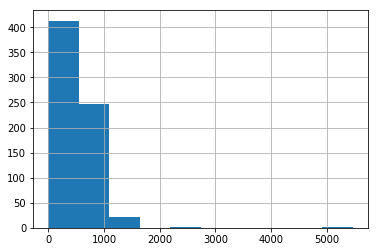

In [16]:
df['DUTIES'].str.len().hist()

### REQUIREMENTS

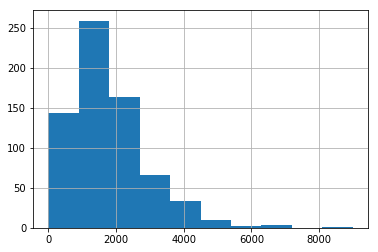

In [17]:
df['REQUIREMENTS'].str.len().hist()

### WHERE TO APPLY

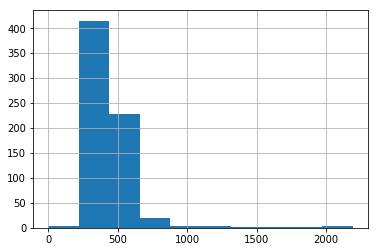

In [18]:
df['WHERE TO APPLY'].str.len().hist()

## How is the salary

In [19]:
df['ANNUAL SALARY'].values[10]

'$48,964 to $69,656NOTES:1. A Senior Animal Keeper is subject to working nights, holidays and weekends on a rotating shift basis at various animal exhibits to meet department needs.2. Candidates from the eligible list are normally appointed to vacancies in the lower pay grade positions.3. The current salary range is subject to change. You may confirm the starting salary with the hiring department before accepting a job offer.'

### What's the salary range?

In [32]:
def get_minmax_salary(s):
    if not s or len(s) == 0:
        return 0, 0
    salary_regex = r'\$[0-9]+,?[0-9]+\.?[0-9]*'
    salaries = re.findall( salary_regex, s)
    if len(salaries)==0:
        return 0, 0
    salaries = list(map(lambda s: float(s.replace('$', '').replace(',', '')), salaries))
    return min(salaries), max(salaries)

In [38]:
salary_minmax = list(map(get_minmax_salary, df['ANNUAL SALARY'].values))
salary_ranges = [max_salary-min_salary for (min_salary, max_salary) in salary_minmax]

(array([125., 244., 175.,  97.,  27.,   4.,   6.,   4.,   0.,   1.]),
 array([     0. ,  17748.1,  35496.2,  53244.3,  70992.4,  88740.5,
        106488.6, 124236.7, 141984.8, 159732.9, 177481. ]),
 <a list of 10 Patch objects>)

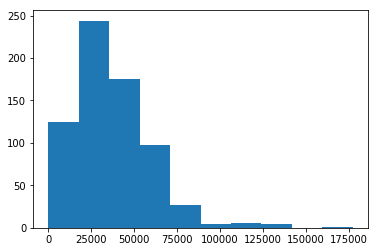

In [33]:
# plot a histogram for the ranges
plt.hist(salary_ranges)

### Tap 10 job listings with higher salary range

In [41]:
top10 = sorted(salary_ranges, reverse=True)[:10]; top10
#salary_ranges.sort(reverse=True); salary_ranges[:10]

[177481.0,
 138685.0,
 133089.0,
 127221.0,
 124842.0,
 120498.0,
 115111.0,
 110357.0,
 108618.0,
 107344.0]

In [45]:
mask = [x in top10 for x in salary_ranges]
df[mask]

,File Name,Class Code,Job Title,Open Date,ANNUAL SALARY,DUTIES,REQUIREMENTS,WHERE TO APPLY,APPLICATION DEADLINE,SELECTION PROCESS
56,POLICE ADMINISTRATOR 9196 100617.txt,9196,POLICE ADMINISTRATOR,2017-10-06,"$119,767 to $175,120; $137,181 to $200,531; $1...","A Police Administrator plans, organizes and di...",1. Two years of full-time paid managerial expe...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, OCT...","After meeting minimum qualifications, candidat..."
102,ELECTRICAL SERVICES MANAGER 092818 REV 100118.txt,5265,ELECTRICAL SERVICES MANAGER,2018-09-28,"$164,764 to $204,707; $185,101 to $229,972; $1...","An Electrical Services Manager plans, directs,...",1. Two years of full-time paid experience as a...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, OCT...",Examination Weights: Essay . . . . . . . . . ...
132,INVESTMENT OFFICER 9146 061518.txt,9146,INVESTMENT OFFICER,2018-06-15,"$93,354 to $136,471; $116,301 to $170,025; and...",An Investment Officer may be responsible for o...,1. Graduation from an accredited four year col...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, JUN...",Examination Weights:\tWritten Test . . . . . ....
514,SENIOR EXAMINER OF QUESTIONED DOCUMENTS 3231 0...,3980,WATER UTILITY SUPERINTENDENT,2016-07-29,"$119,433 to $148,394; $134,362 to $166, 935; a...","A Water Utility Superintendent plans, organize...",Three years of full-time paid experience as a ...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, AUG...","After meeting minimum qualifications, candidat..."
538,SUPPLY SERVICES MANAGER 1865 092818.txt,1865,SUPPLY SERVICES MANAGER,2018-09-28,"$102,353 to $149,667 and $123,066 to $179,943T...","A Supply Services Manager plans, organizes and...",1. Two years of full time paid experience with...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, OCT...",Examination Weight: Essay . . . . . . . . . ....
540,WASTEWATER TREATMENT OPERATOR 120718.txt,4123,WASTEWATER TREATMENT OPERATOR,2018-12-07,"$94,361; $104,671; and $110,382 (flat-rated)NO...",A Wastewater Treatment Operator operates waste...,1. Current employment with the City of Los Ang...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, DEC...",Examination Weight: Application Review . . . ...
569,PRINCIPAL UTILITY ACCOUNTANT 1589 030218 updat...,1589,PRINCIPAL UTILITY ACCOUNTANT,2018-03-02,"$121,312 to $150,711; $138,330 to $171,863; $1...","A Principal Utility Accountant plans, directs,...",Two years of full-time paid professional accou...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, MAR...","After meeting the minimum qualification, candi..."
586,POWER ENGINEERING MANAGER 9453 042817 (1).txt,9453,POWER ENGINEERING MANAGER,2017-04-28,"$145,638 to $180,966; $153,760 to $191,052; $1...",A Power Engineering Manager may serve as the m...,1. Two years of full-time paid experience with...,Applications will only be accepted on-line. Wh...,Applications must be submitted on-line by THUR...,"After meeting minimum qualifications, candidat..."
642,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,9406,MANAGING WATER UTILITY ENGINEER,2017-03-24,"$148,561 to $184,579; $156,850 to $194,873; $1...",A Managing Water Utility Engineer may serve as...,1. Two years of full-time paid experience at t...,Applications will only be accepted on-line. W...,"Applications must be received by THURSDAY, APR...","After meeting minimum qualifications, candidat..."
661,PORTFOLIO MANAGER 9143 082517.txt,9143,PORTFOLIO MANAGER,2017-08-25,"$127,910 to $187,022 and $160,880 to $235,254N...",The Portfolio Manager is responsible for the d...,1. A Bachelor's degree from an accredited four...,Applications will only be accepted on-line. W...,Applications and Qualifications

## Job listings over year

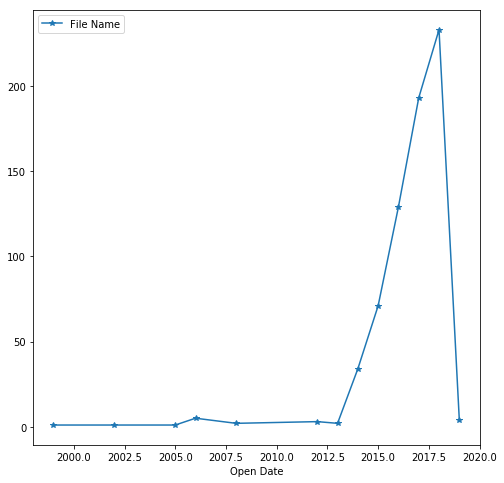

In [46]:
df.groupby(df['Open Date'].dt.year).agg({'File Name': 'count'}).plot(figsize=(8, 8), marker='*')

### How does the job listings changes over month

In [ ]:
df.groupby(df['Open Date'].dt.month).agg({'File Name': 'count'}).plot(figsize=(8, 8), kind='bar')

### Popular job class

In [47]:
doc = nlp_en(' '.join(df['Job Title'].values).lower())

In [48]:
# all tokens that arent stop words or punctuations
words = [token.text for token in doc if not (token.is_stop or token.is_punct or token.is_space)]
# noun tokens that arent stop words or punctuations
nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

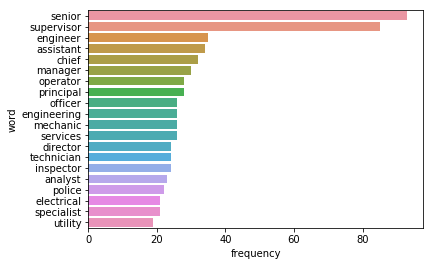

In [49]:
ax = sns.barplot(y='word', x='frequency', data=pd.DataFrame(Counter(words).most_common(20), columns=['word', 'frequency']))

## Readability

### Exploring sentenses length

In [50]:
nlp_en.add_pipe(nlp_en.create_pipe('sentencizer')) # enable spacy to split sentences

In [51]:
#doc2 = list(map(lambda text: [sent for sent in nlp_en(text.lower()).sents], df['Job Title'].values))
doc2 = [sent for sent in nlp_en(df['REQUIREMENTS'].values[0].lower()).sents]

In [120]:
sents_len = list(map(lambda text: [len(sent) for sent in nlp_en(text.lower()).sents], df['REQUIREMENTS'].values))

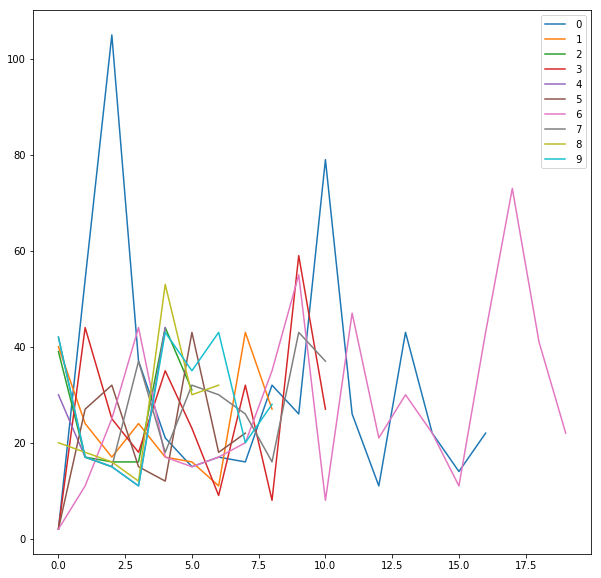

In [121]:
fig = plt.figure(figsize=(10, 10))
start, end = 0, 10
for i in range(start, end):
    plt.plot(sents_len[i], label=('%2d' % i))
plt.legend()

(array([185., 337., 106.,  45.,   3.,   4.,   0.,   1.,   0.,   2.]),
 array([ 0. ,  7.6, 15.2, 22.8, 30.4, 38. , 45.6, 53.2, 60.8, 68.4, 76. ]),
 <a list of 10 Patch objects>)

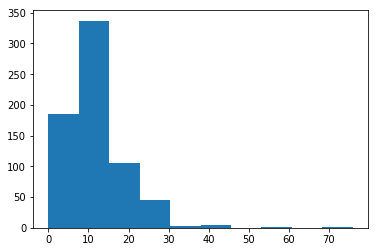

In [122]:
plt.hist([len(sl) for sl in sents_len])

few job postings have over 30 sentence, let's trim at 30 and pad those with fewer sentences

In [125]:
# pad the array of sentences length
def right_pad(a, m):
    while len(a)<m: a.append(0)
    return a
max_len = min(30, max([len(sl) for sl in sents_len]))

trimed_sents_len = [sl if len(sl)<=max_len else sl[:max_len] for sl in sents_len]

padded_sents_len = [sl if len(sl)==max_len else right_pad(sl, max_len) for sl in trimed_sents_len]

displaying the sentences lengths with a heatmap

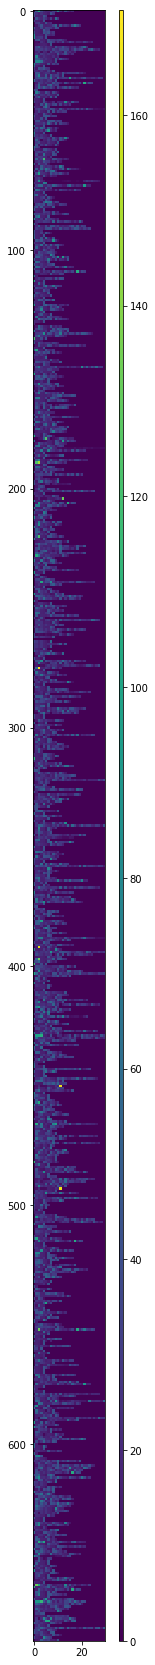

In [141]:
arr = np.array(padded_sents_len)

plt.figure(figsize=(30, 30))
ax = plt.gca()
im = ax.imshow(arr, cmap='viridis')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

plt.colorbar(im, cax=cax)
plt.show()

## Gender bias

### Gender bias in Requirements section

In [54]:
nlp_en_web = spacy.load('en_core_web_sm')

In [55]:
requirements_doc = nlp_en_web(df['REQUIREMENTS'].values[0].lower())
requirements_tag_df = pd.DataFrame([(token.text, token.pos_) for token in requirements_doc], columns=['word', 'tag'])
requirements_tag_df.head()

,word,tag
0,1,PUNCT
1,.,PUNCT
2,a,DET
3,bachelor,NOUN
4,'s,PART


looking for pronouns that could indicate gender bias

In [56]:
requirements_tag_df['tag'].unique()

array(['PUNCT', 'DET', 'NOUN', 'PART', 'ADP', 'ADJ', 'NUM', 'CCONJ',
       'SYM', 'VERB', 'ADV', 'PRON', 'AUX', 'SPACE', 'INTJ'], dtype=object)

In [57]:
requirements_tag_df[requirements_tag_df['tag']=='PRON']

,word,tag
199,who,PRON
221,they,PRON
235,who,PRON
254,they,PRON
300,who,PRON
405,who,PRON


### Gender bias in Duties section

In [58]:
duties_doc = nlp_en_web(df['DUTIES'].values[0].lower())
duties_tag_df = pd.DataFrame([(token.text, token.pos_) for token in duties_doc], columns=['word', 'tag'])
duties_tag_df.head()

,word,tag
0,an,DET
1,arts,NOUN
2,associate,NOUN
3,performs,VERB
4,a,DET


looking for pronouns that could indicate gender bias

In [59]:
duties_tag_df['tag'].unique() # no pronoun use

array(['DET', 'NOUN', 'VERB', 'ADJ', 'ADP', 'PUNCT', 'CCONJ'],
      dtype=object)

To be continued.